# W2246-0526 IFU Data Visualization

This notebook analyzes and visualizes 3D spectral cube data from the hyperluminous infrared galaxy **W2246-0526** at redshift z=4.6, observed with ALMA in the [CII] 158μm line.

## Scientific Context

**W2246-0526** is one of the most luminous galaxies known in the universe, classified as a Hot Dust-Obscured Galaxy (Hot DOG). This analysis focuses on:

- **Redshift**: z = 4.6 (cosmic time ~1.2 Gyr after Big Bang)  
- **Emission line**: [CII] 158μm fine-structure transition
- **Instrument**: ALMA (Atacama Large Millimeter/submillimeter Array)

## Analysis Pipeline

This notebook performs:

### 1. **Data Loading & Preprocessing**
- Loads ALMA spectral cube from FITS file
- Spatial cropping to focus on the galaxy region
- Coordinate system and WCS handling
- Unit conversions and cosmological scaling

### 2. **Moment Map Analysis**
- **Moment 0**: Integrated [CII] flux map (velocity-integrated emission)
- **Moment 1**: Velocity-weighted map (kinematics/rotation)
- **Dendrogram masking**: Structure identification to avoid noise bias
- **Beam deconvolution**: Accounts for telescope point spread function

### 3. **Velocity Spectrum Extraction**
- Spatially-integrated line profile
- Shows the overall [CII] emission characteristics
- Reveals velocity structure and line width

## Key Scientific Goals

- Map the spatial distribution of star formation activity via [CII] emission
- Study galaxy kinematics and potential rotation/outflows  
- Measure the total [CII] luminosity and compare to models
- Understand the structure of this extreme high-redshift galaxy


### Output Products
- Publication-quality PDF figures saved to `figures/W2246` directory
- Quantitative measurements of line flux and spatial extent


## Requirements

- `spectral_cube`: For handling 3D astronomical data cubes
- `astropy`: Coordinate systems, cosmology, and FITS file handling
- `astrodendro`: Structure identification in 3D data
- `matplotlib`: Publication-quality plotting
- Custom `functions.py`: Local utilities for beam handling

Pixel scale: 0.334 kpc/pixel


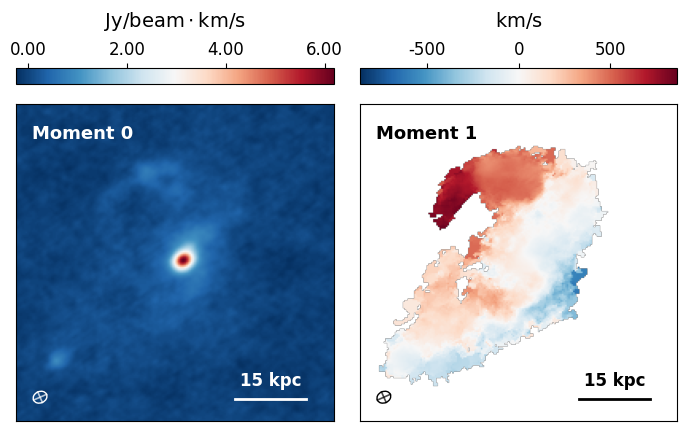

In [ ]:
"""
W2246-0526 Data Analysis: Import Libraries and Setup

This cell imports all necessary libraries for:
- Spectral cube handling and analysis (spectral_cube, astropy)
- Structure identification (astrodendro) 
- Visualization (matplotlib)
- Cosmological calculations (astropy.cosmology)
- Custom beam handling utilities (functions.py)
"""

# Core scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Astronomy-specific libraries
from astropy.wcs import WCS
from astropy.io import fits
from spectral_cube import SpectralCube
from astropy.convolution import Gaussian2DKernel, convolve_fft
from astrodendro import Dendrogram
from astropy.cosmology import Planck18
from astropy import units as u

# Plotting utilities
from mpl_toolkits.axes_grid1 import make_axes_locatable

# =============================================================================
# DATA LOADING AND INITIAL SETUP
# =============================================================================

# Load the W2246-0526 ALMA [CII] spectral cube
fname = '/Users/arnablahiry/Work/data/W2246/W2246_C2_125.fits'
cube = SpectralCube.read(fname)


# =============================================================================
# SPATIAL CROPPING TO FOCUS ON GALAXY REGION  
# =============================================================================

# Define spatial crop region to isolate the galaxy and reduce data size
# Original cube is large; we crop to ~200x200 pixel region around the galaxy
from spectral_cube import SpectralCube

# Define pixel slices (example: crop spatial axes only)
# Suppose cube shape is (velocity, y, x)
# Crop y from 200 to 400, x from 200 to 400, keep all velocity channels
slices = (slice(None), slice(200, 400), slice(200, 400))

# Crop the cube spatially
# Suppose you want to crop x pixels from 200 to 400, y pixels 200 to 400
cropped_cube = cube.subcube(xlo=195, xhi=395, ylo=200, yhi=400)

# The subcube preserves WCS and beam info automatically

# Save the cropped cube to a new FITS file
#cropped_cube.write('cropped_cube.fits', overwrite=True)

# Save if needed
#cropped_cube.write("/Users/arnablahiry/Work/data/W2246/CROPPED_ONLY_SPATIAL_W2246_CII_125.fits", overwrite=True)

# =============================================================================
# COSMOLOGICAL PARAMETERS AND PIXEL SCALE CALCULATION
# =============================================================================

# Extract header information for coordinate calculations
header = cropped_cube.header

# --- Cosmology ---
z = 4.6  # Redshift of W2246-0526
kpc_per_arcsec = Planck18.kpc_proper_per_arcmin(z).to('kpc/arcsec').value

# --- Pixel scale ---
pixscale_deg = abs(header['CDELT1'])             # deg/pixel
pixscale_arcsec = pixscale_deg * 3600            # arcsec/pixel
pixscale_kpc = pixscale_arcsec * kpc_per_arcsec  # kpc/pixel
print(f"Pixel scale: {pixscale_kpc:.3f} kpc/pixel")

# --- Get unitless moment-0 map ---
data = cropped_cube.unmasked_data[:]  # astropy Quantity (Jy/beam or Jy/pixel)
data = data.value             # strip units → plain numpy array



# =============================================================================
# DENDROGRAM MASKING FOR STRUCTURE IDENTIFICATION
# =============================================================================

# Create mask to identify significant emission regions and avoid noise bias
# in moment calculations. Uses dendrogram algorithm to find connected structures.
mask = np.zeros(data.shape, dtype=bool)
d1 = Dendrogram.compute(data, 
                       min_value=1.3 * data.std(),  # Minimum detection threshold 
                       min_delta=3*data.std(),      # Minimum contrast for peaks
                       verbose=False)
for trunk in d1.trunk:
    mask |= trunk.get_mask()

    
# =============================================================================
# BEAM INFORMATION EXTRACTION
# =============================================================================

# Extract beam parameters from FITS file for proper beam representation
hdul_real_data = fits.open(fname)

# Load beam table (ALMA data often has variable beam sizes per channel)
beam_info = hdul_real_data[1]
beam_data = beam_info.data  # this is a structured array

# Extract each field and take the mean across channels, convert to pixels
bmaj = beam_data['BMAJ'].mean()/pixscale_arcsec  # Major axis in pixels
bmin = beam_data['BMIN'].mean()/pixscale_arcsec  # Minor axis in pixels  
bpa  = beam_data['BPA'].mean()                   # Position angle in degrees  


# =============================================================================
# VELOCITY AXIS SETUP AND MOMENT CALCULATIONS
# =============================================================================

# Import custom beam handling functions
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import importlib
# Local utility functions for IFU processing
import sys
import os
sys.path.append(os.path.abspath('/Users/arnablahiry/repos/3D_IFU_Denoising/src'))
from functions import *           


# Get image shape and extent for plotting
ny, nx = data.shape[1], data.shape[2]
x_max = nx# * pix_spatial_scale
y_max = ny# * pix_spatial_scale
extent = [0, x_max, 0, y_max]  # (xmin, xmax, ymin, ymax)

# Define tick locations (in kpc)
num_ticks = 5
tick_locs = np.linspace(0, x_max, num_ticks)
tick_labels = [f"{tick:.1f}" for tick in tick_locs]

# Sum the flux over all pixels (spatially integrated spectrum)
integrated_spectrum = cube.filled_data[:].sum(axis=(1, 2))  # Sum over the x and y axes

# Setup velocity coordinate system
rest_freq = cube.header['RESTFRQ'] * u.Hz  # Rest frequency of [CII] line

# Get the original frequency axis (in Hz)
frequency_axis = cube.spectral_axis

# Convert the frequency axis to velocity (km/s) using radio doppler convention
velocity_axis = frequency_axis.to(u.km / u.s, equivalencies=u.doppler_radio(rest_freq)).value

# Calculate velocity channel width and create moment cube for moment-1 calculation
cdelt = velocity_axis[1]-velocity_axis[0]
moment_cube = data * velocity_axis[:, np.newaxis, np.newaxis]  # Calculate the moment cube



# =============================================================================
# MOMENT MAP VISUALIZATION 
# =============================================================================

# Create side-by-side moment 0 and moment 1 maps
fig, ax = plt.subplots(1, 2, figsize=(7, 5), sharex=True, sharey=True)

# Left panel: Moment 0 map (integrated [CII] flux)
im0 = ax[0].imshow(data.sum(axis=0)*cdelt, cmap='RdBu_r', origin='lower', extent=extent)
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("top", size="5%", pad=0.2)
cb0 = fig.colorbar(im0, cax=cax0, orientation='horizontal', format='%.2f')
#cb0.set_label(r'$\rm Jy\;beam^{-1}\cdot km\;s^{-1}$', rotation=0, labelpad=10, fontsize=15)
cb0.set_label(r'$\rm Jy/beam\cdot km/s$', rotation=0, labelpad=10, fontsize=15)
cb0.ax.xaxis.set_label_position('top')
cb0.ax.xaxis.set_ticks_position('top')
cb0.ax.xaxis.label.set_size(14)
cb0.ax.tick_params(labelsize=12)  # <--- Make tick labels larger
cb0.ax.xaxis.labelpad = 10
ax[0].text(x_max * 0.05, y_max * 0.89, 'Moment 0', color='white', fontsize=13, weight='bold')
add_beam(ax[0], bmin, bmaj, 90+bpa, xy_offset=(15, 15), color='white')




# Right panel: Moment 1 map (intensity-weighted velocity field)
# This shows the kinematics - redshifted and blueshifted regions
numerator = (mask * moment_cube).sum(axis=0)
denominator = (mask * data).sum(axis=0)
ratio = np.divide(numerator, denominator, out=np.full_like(numerator, np.nan), where=denominator != 0)
max = np.max([np.abs(np.nanmin(ratio)), np.abs(np.nanmax(ratio))])
im1 = ax[1].imshow(ratio, cmap='RdBu_r', origin='lower', extent=extent, vmin=-max, vmax=max)
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("top", size="5%", pad=0.2)
cb1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', format='%.0f')
#cb1.set_label(r'$\rm km\;s^{-1}$', rotation=0, labelpad=10, fontsize=15)
cb1.set_label(r'$\rm km/s$', rotation=0, labelpad=10, fontsize=15)
cb1.ax.xaxis.set_label_position('top')
cb1.ax.xaxis.set_ticks_position('top')
cb1.ax.tick_params(labelsize=12)  # <--- Make tick labels larger
cb1.ax.xaxis.label.set_size(14)
cb1.ax.xaxis.labelpad = 10
ax[1].text(x_max * 0.05, y_max * 0.89, 'Moment 1', color='black', fontsize=13, weight='bold')
add_beam(ax[1], bmin, bmaj, 90+bpa, xy_offset=(15, 15), color='black')

# Clean up axis appearance - remove tick marks for cleaner presentation
# Remove ticks and labels
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
    a.set_xlabel('')
    a.set_ylabel('')

# Add scale bars for physical size reference (15 kpc)
kpc = 15
scalebar_length = kpc/pixscale_kpc  # Convert kpc to pixels
x0 = x_max * 0.69
y0 = y_max * 0.07

# Scalebar for Moment 0
ax[0].plot([x0, x0 + scalebar_length], [y0, y0], color='white', lw=2)
ax[0].text(x0 + scalebar_length / 2, y0 + y_max * 0.03, f'{kpc} kpc',
           color='white', ha='center', va='bottom', fontsize=12, weight='bold')

# Scalebar for Moment 1
ax[1].plot([x0, x0 + scalebar_length], [y0, y0], color='black', lw=2)
ax[1].text(x0 + scalebar_length / 2, y0 + y_max * 0.03, f'{kpc} kpc',
           color='black', ha='center', va='bottom', fontsize=12, weight='bold')

# Ensure equal aspect ratio for proper spatial representation
for a in ax:
    a.set_aspect('equal')  # or 'auto' if stretching is preferred


plt.tight_layout()
plt.savefig('figures/moment_maps_w2246.pdf', bbox_inches='tight')
plt.show()

## Velocity Spectrum Analysis

The velocity spectrum shows the total [CII] flux as a function of line-of-sight velocity, obtained by spatially integrating the emission at each velocity channel. This 1D profile reveals:

### Key Information from Velocity Spectra:

- **Line width**: Indicates velocity dispersion from rotation, turbulence, or outflows
- **Line shape**: Asymmetries can reveal complex kinematics or multiple components  
- **Total flux**: Integrated area gives the total [CII] luminosity
- **Velocity centroid**: Shows the systemic velocity of the galaxy

### Analysis Notes:

- The spectrum is extracted by summing flux across all spatial pixels at each velocity
- No spatial masking is applied here to show the raw integrated profile
- This represents the emission that would be seen in a single-dish (unresolved) observation
- Comparison with moment maps reveals how much spatial structure would be lost in lower-resolution observations

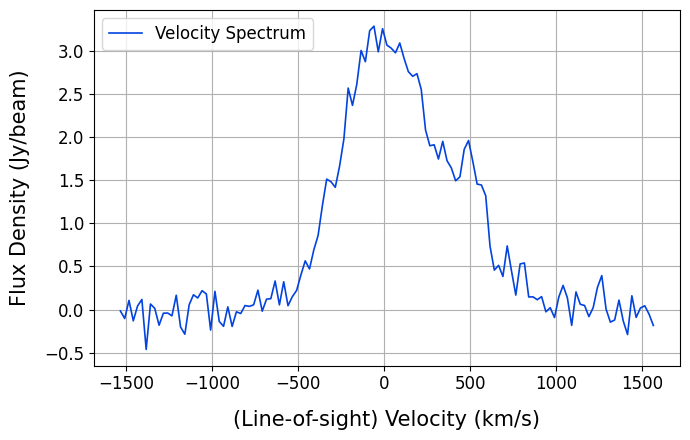

In [ ]:
"""
Velocity Spectrum Visualization

Creates a 1D plot showing the spatially-integrated [CII] emission 
as a function of line-of-sight velocity. This reveals the overall
line profile characteristics and total luminosity of W2246-0526.
"""

# Create velocity spectrum plot
plt.figure(figsize = (7, 4.5))
#plt.plot(vels, np.sum(convolved_cube, axis=(1,2)), color='xkcd:blue', label='Velocity Spectrum', linewidth=0.8, alpha=0.3)

# Import smoothing function for cleaner spectrum if needed
from scipy.ndimage import gaussian_filter1d

# Sum flux over all spatial pixels to get integrated spectrum
y_smooth = np.sum(data, axis=(1,2))

# Plot the velocity spectrum
plt.plot(velocity_axis, y_smooth, color='xkcd:blue', label='Velocity Spectrum', linewidth=1.2)
plt.ylabel('Flux Density (Jy/beam)', fontsize=15, labelpad = 10)
plt.xlabel('(Line-of-sight) Velocity (km/s)', fontsize=15, labelpad = 12)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.grid(True)
plt.legend(fontsize = 12, loc='upper left')
plt.tight_layout()
plt.savefig('figures/init_velocity_spectrum_w2246.pdf', bbox_inches='tight')
plt.show()